# Notebook: Compare empirical PSFs with synthetic PSFs - grid

**Author**: Matteo Correnti, STScI Scientist II
<br>
**Created**: December, 2021
<br>
**Last Updated**: February, 2022

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [Select detector and filter](#sel_det)<br>
3. [Load PSFs](#load_psf)<br>
    3.1 [Load empirical PSFs](#load_epsf)<br>
    3.2 [Retrieve centers of the empirical PSFs](#epsf_center)<br>
    3.3 [Load synthetic PSFs](#load_webbpsf)<br>
4. [Derive the radial profiles](#radial_profiles)<br>
    4.1 [Determine the center of the PSF](#find_center)<br>
    4.2 [Calculate radial profile](#rp_method)<br>
    4.3 [Display radial profiles comparison between WebbPSF and ePSF](#plot_rp)<br>
    4.4 [Display differences between WebbPSF (ePSF) PSFs](#diff_psf)<br>


1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

This notebook shows how to derive the radial profile of a PSF, in order to compare the empirical PSF obtained from the observations with the synthetic PSF obtained from WebbPSF. Here we compare the synthetic PSF grid with the empirical one for one combination of detector/filter.

**Dependencies**: before running this notebook it is necessary to create the synthetic model PSFs using the notebook `NRC_webbpsf.ipynb` and the empirical PSFs using the notebook `NRC_create_ePSF.ipynb` or created using other codes. 

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary Python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os 

os.environ['WEBBPSF_PATH'] = '/grp/jwst/ote/webbpsf-data'
os.environ['PYSIN_CDBS'] = '/grp/hst/cdbs/'

import glob as glob

import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot

from photutils.centroids import centroid_2dg, centroid_sources, centroid_com
from photutils import CircularAperture, CircularAnnulus, aperture_photometry


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-039 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-044
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### 2.2<font color='white'>-</font>Plotting function imports<a class="anchor" id="matpl_imports"></a> ###

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [3]:
figures_dir = '../../Imaging_Webinar/Analysis_NEW/FIGURES/'

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

### 2.3<font color='white'>-</font>Select detector and filter<a class="anchor" id="sel_det"></a> ###

In [4]:
det = 'NRCB1'
filt = 'F200W'

3.<font color='white'>-</font>Load PSFs models<a class="anchor" id="load_psf"></a>
------------------

### 3.1<font color='white'>-</font>Load empirical PSFs<a class="anchor" id="load_epsf"></a> ###

In [5]:
distorted = True
fov = 41
oversample = 4
num_psf_epsf = 4


if distorted:

    dir_epsf = '../../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Distorted/Grid/Fov{}px_numPSFs{}_oversample{}'.format(fov, num_psf_epsf, oversample)
    
    
    epsfs = sorted(glob.glob(os.path.join(dir_epsf, '*'+det+'_'+filt+'*')))

else:
    
    dir_epsf = './../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Undistorted/Fov{}px_numPSFs{}_oversample{}'.format(fov, num_psf, oversample)
    epsfs = sorted(glob.glob(os.path.join(dir_epsf, '*'+det+'_'+filt+'*')))

print('Empirical PSFs:', epsfs)


Empirical PSFs: ['../../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Distorted/Grid/Fov41px_numPSFs4_oversample4/ePSF_NRCB1_F200W_fov41_nepsf4_image_1.fits', '../../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Distorted/Grid/Fov41px_numPSFs4_oversample4/ePSF_NRCB1_F200W_fov41_nepsf4_image_2.fits', '../../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Distorted/Grid/Fov41px_numPSFs4_oversample4/ePSF_NRCB1_F200W_fov41_nepsf4_image_3.fits', '../../Imaging_Webinar/Analysis_NEW/ePSF_MODELS/Distorted/Grid/Fov41px_numPSFs4_oversample4/ePSF_NRCB1_F200W_fov41_nepsf4_image_4.fits']


### 3.2<font color='white'>-</font>Retrieve centers of the empirical PSFs<a class="anchor" id="epsf_center"></a> ###

To load the synthetic PSFs created with WebbPSF in the right orders, we retrieve the centers of the empirical PSFs and we save the positions in an array

In [6]:
epsfs[0]
im = to_griddedpsfmodel(epsfs[0])
pos = im.meta['grid_xypos']
print('empirical PSF centers:', pos)

empirical PSF centers: [(511.0, 511.0), (511.0, 1533.0), (1533.0, 511.0), (1533.0, 1533.0)]


### 3.3<font color='white'>-</font>Load synthetic PSFs<a class="anchor" id="load_webbpsf"></a> ###

In [8]:
distorted = True
fov = 41
oversample = 4
num_psf_webb = 1

if distorted:

    dir_webbpsf = '../../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Distorted/Fov{}px_numPSFs{}_oversample{}'.format(fov, num_psf_webb, oversample)

else:
    
    dir_webbpsf = './../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Undistorted/Fov{}px_numPSFs{}_oversample{}'.format(fov, num_psf_webb, oversample)

psf_webbpsf = []

for p in pos:
    
    x0 = (str(p[0])[:-2])
    y0 = (str(p[1])[:-2])
    #print(x0, y0)
    
    psf = glob.glob(os.path.join(dir_webbpsf, '*'+filt+'*'+x0+'*'+y0+'*'+str.lower(det)+'*'))[0]
    psf_webbpsf.append(psf)
psf_webbpsf

['../../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Distorted/Fov41px_numPSFs1_oversample4/PSF_F200W_fov41_npsfs1_x511_y511_nrcb1.fits',
 '../../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Distorted/Fov41px_numPSFs1_oversample4/PSF_F200W_fov41_npsfs1_x511_y1533_nrcb1.fits',
 '../../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Distorted/Fov41px_numPSFs1_oversample4/PSF_F200W_fov41_npsfs1_x1533_y511_nrcb1.fits',
 '../../Imaging_Webinar/Analysis_NEW/PSF_MODELS/Distorted/Fov41px_numPSFs1_oversample4/PSF_F200W_fov41_npsfs1_x1533_y1533_nrcb1.fits']

4.<font color='white'>-</font>Derive the radial profiles<a class="anchor" id="radial_profiles"></a>
------------------

To derive the radial profile we use aperture photometry at increasingly larger radii. 

More information on aperture photometry using Photutils can be found here: [Aperture Photometry](https://photutils.readthedocs.io/en/stable/aperture.html). In the function below, to calculate the radial profile, we first determine the aperture photometry at different radii, then we derive the flux in each annulus and divide by the appropriate area. 

### 4.1<font color='white'>-</font>Determine the center of the PSF<a class="anchor" id="find_center"></a> ###

In [9]:
def find_center(data, centroid_func=centroid_com):

    xcenter = data.shape[1] / 2
    ycenter = data.shape[0] / 2
    
    xc, yc = centroid_sources(data, xcenter, ycenter, box_size=21, centroid_func=centroid_func)
    
    return xc, yc

### 4.2<font color='white'>-</font>Calculate radial profile<a class="anchor" id="rp_method"></a> ###

In [10]:
def ap_phot(data, positions, radii, rsky):
    
    zero_mask = np.where(data == 0,0,1)
    nan_mask  = np.where(np.isnan(data),0,1)
    zero_mask = nan_mask * zero_mask
    
    nan_mask = np.where(zero_mask == 0,True,False)

    apflux = []
    apflux_err = []
    area = []
     
    for r in radii:
        
        aperture = CircularAperture(positions, r=r)
        aperture_area = aperture.area

        annulus_aperture = CircularAnnulus(positions, r_in=rsky[0], r_out=rsky[1])
        annulus_mask = annulus_aperture.to_mask(method='center')
        
        local_sky_median = []
        local_sky_stdev = []
        
        annulus_data = annulus_mask.multiply(data)
        annulus_data_1d = annulus_data[annulus_mask.data > 0]
        
        annulus_data_1d = annulus_data_1d[np.isfinite(annulus_data_1d)]
            
        _, median_sigclip, stdev_sigclip = sigma_clipped_stats(annulus_data_1d)
        
        local_sky_median.append(median_sigclip)
        local_sky_median = np.array(local_sky_median)
        local_sky_stdev.append(stdev_sigclip)
        local_sky_stdev = np.array(local_sky_stdev)
       
        phot = aperture_photometry(data, aperture, method='exact', mask=nan_mask)
        
        phot['aper_bkg'] = local_sky_median * aperture.area
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
        
        aperture_sum = phot['aper_sum_bkgsub'][0]
    
        error_poisson = phot['aperture_sum']
        error_scatter_sky = aperture.area * local_sky_stdev**2
        error_mean_sky = local_sky_stdev**2 * aperture.area**2 / annulus_aperture.area
        
        ap_err = np.sqrt(error_poisson + error_scatter_sky + error_mean_sky)
         
        apflux.append(aperture_sum)
        apflux_err.append(ap_err)
        area.append(aperture_area)

    return apflux, area

In [11]:
def calc_profile(image, model='webbpsf', num=0, norm=True, peak=True):
    
    if model=='webbpsf':
        
        im = to_griddedpsfmodel(image)
        data = im.data[0]
        fov = data.shape[1]
    
    if model=='epsf':
        
        im = to_griddedpsfmodel(image)
        data = im.data[num]
        fov = data.shape[1] - 1
        print('Analyzing ePSF at position:', im.meta['det_yx'+str(num)])
    
    xc, yc = find_center(data, centroid_func=centroid_com)

    positions = (xc[0], yc[0])
    print('Center calcuated with centroid function: X =', positions[0], 'Y =', positions[1])
    
    radii = np.arange(2, data.shape[1]/2 -6, 2)
    rsky = [data.shape[1]/2 - 5, data.shape[1]/2 - 1]
    
    apflux, area = ap_phot(data, positions, radii, rsky)
    
    diff = np.zeros(len(apflux))
    encircled = np.zeros(len(apflux))
    
    diff[0] = apflux[0]
    encircled[0] = apflux[0] / area[0]
    
    sum_ee = encircled[0]
    
    ii = 0 
    
    for ii in range(1, len(apflux)):
        diff[ii] = apflux[ii] - apflux[ii - 1]
        encircled[ii] = diff[ii] / (area[ii] - area[ii - 1])
        sum_ee = sum_ee + encircled[ii]
        
    if norm:
        diff = diff / diff[0]
        
        if peak:
            
            encircled = encircled / encircled[0]
        else:
            
            encircled = encircled / sum_ee
    
    return diff, encircled, radii, fov
    

In [12]:
diff_webbpsf_tot = []
en_webbpsf_tot = []



for psf in psf_webbpsf:
    diff_webbpsf, en_webbpsf, radii_webbpsf, fov_webbpsf = calc_profile(psf, model='webbpsf', 
                                                                       norm=True, peak=False)
    
    
    diff_webbpsf_tot.append(diff_webbpsf)
    en_webbpsf_tot.append(en_webbpsf)

Center calcuated with centroid function: X = 81.53485613245496 Y = 81.59025131431078
Center calcuated with centroid function: X = 81.55940650202086 Y = 81.58956005156719
Center calcuated with centroid function: X = 81.55957126737141 Y = 81.56948850071949
Center calcuated with centroid function: X = 81.56633774258911 Y = 81.55367421048595


In [13]:
diff_epsf_tot = []
en_epsf_tot = []

for i in range(num_psf_epsf):
    
    diff_epsf, en_epsf, radii_epsf, _ = calc_profile(epsfs[0], num=i, model='epsf', norm=True, peak=False)
   
    
    diff_epsf_tot.append(diff_epsf)
    en_epsf_tot.append(en_epsf)
    


Analyzing ePSF at position: ('(511.0, 511.0)', "The #0 PSF's (y,x) detector pixel position")
Center calcuated with centroid function: X = 81.54890713449463 Y = 81.85525398697122
Analyzing ePSF at position: ('(1533.0, 511.0)', "The #1 PSF's (y,x) detector pixel position")
Center calcuated with centroid function: X = 82.21148205876554 Y = 82.39112265629507
Analyzing ePSF at position: ('(511.0, 1533.0)', "The #2 PSF's (y,x) detector pixel position")
Center calcuated with centroid function: X = 82.14276371859052 Y = 81.8029657862383
Analyzing ePSF at position: ('(1533.0, 1533.0)', "The #3 PSF's (y,x) detector pixel position")
Center calcuated with centroid function: X = 81.73835748599849 Y = 81.77013225905742


In [14]:
def pix2arcsec_sw(x):
    return x * 0.031
def arcsec2pix_sw(x):
    return x / 0.031
def pix2arcsec_lw(x):
    return x * 0.063
def arcsec2pix_lw(x):
    return x / 0.063

### 4.3<font color='white'>-</font>Display radial profiles comparison between WebbPSF and ePSF<a class="anchor" id="plot_rp"></a> ###

<Figure size 432x288 with 0 Axes>

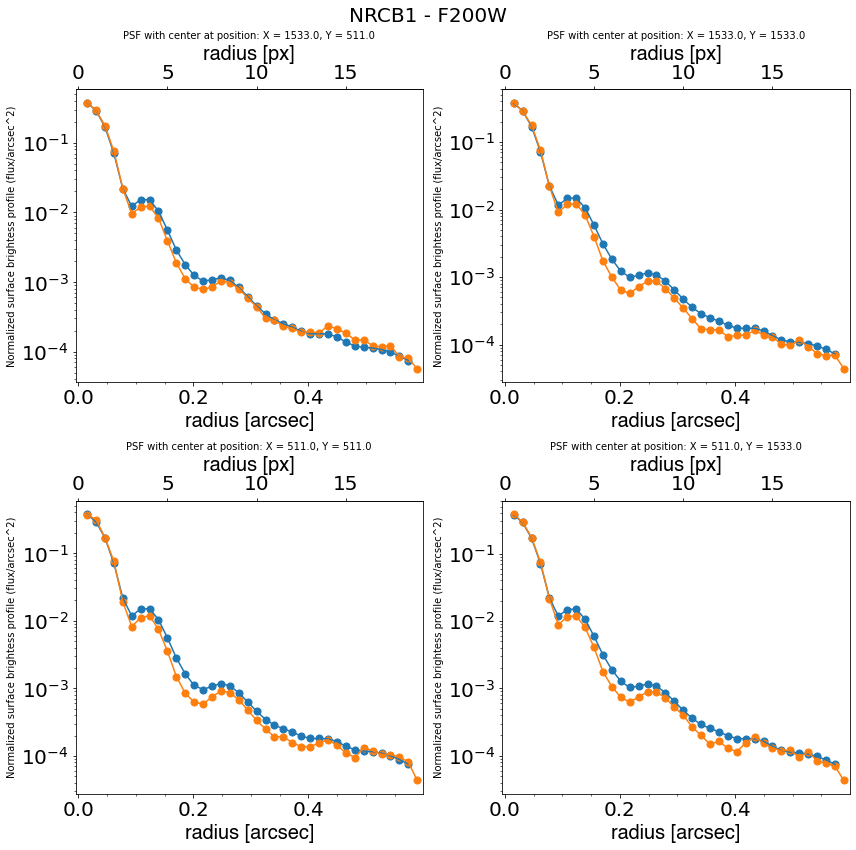

In [17]:
oversample = 4
rad_arcsec_webbpsf = pix2arcsec_sw(radii_webbpsf / 4)
rad_arcsec_epsf = pix2arcsec_sw(radii_epsf / 4)
fov_detsamp = int(fov_webbpsf / 4)

plt.suptitle(det+' - '+ filt, fontsize=30)

nn = int(np.sqrt(num_psf_epsf))
figsize = (12, 12)
fig, ax = plt.subplots(nn, nn, figsize=figsize)

for ix in range(nn):
    for iy in range(nn):
            
        i = ix * nn + iy
             
        plt.suptitle(det + ' - ' + filt, fontsize=20)
        
        xlim0 = rad_arcsec_epsf[0] - 0.02
        xlim1 = np.max(rad_arcsec_epsf) + 0.01

        ax[nn - 1 - ix, iy].set_xlim(xlim0, xlim1)
        ax[nn - 1 - ix, iy].set_title('PSF with center at position: X = {}, Y = {}'.format(pos[i][0], pos[i][1]), fontsize=10)
        ax[nn - 1 - ix, iy].set_xlabel('radius [arcsec]', fontdict=font2)
        ax[nn - 1 - ix, iy].set_ylabel('Normalized surface brightess profile (flux/arcsec^2)', fontsize=10)
    
        ax[nn - 1 - ix, iy].xaxis.set_major_locator(ticker.AutoLocator())
        ax[nn - 1 - ix, iy].xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax[nn - 1 - ix, iy].yaxis.set_major_locator(ticker.AutoLocator())
        ax[nn - 1 - ix, iy].yaxis.set_minor_locator(ticker.AutoMinorLocator())
        
        ax[nn - 1 - ix, iy].scatter(rad_arcsec_webbpsf, en_webbpsf_tot[i], s=50)
        ax[nn - 1 - ix, iy].semilogy(rad_arcsec_webbpsf, en_webbpsf_tot[i])
        ax[nn - 1 - ix, iy].scatter(rad_arcsec_epsf, en_epsf_tot[i], s=50)
        ax[nn - 1 - ix, iy].semilogy(rad_arcsec_epsf, en_epsf_tot[i])
        
        ax[nn - 1 - ix, iy] = ax[nn - 1 - ix, iy].secondary_xaxis('top', functions=(arcsec2pix_sw, pix2arcsec_sw))
        ax[nn - 1 - ix, iy].set_xlabel('radius [px]', fontdict=font2)

            
        plt.tight_layout()

filename = 'radial_profile_{}_{}_fov{}px_numPSF{}.png'.format(det, filt, fov_detsamp, num_psf_epsf)
    
#plt.savefig(os.path.join(figures_dir, filename))

### 4.4<font color='white'>-</font>Display differences between WebbPSF (ePSF) PSFs<a class="anchor" id="diff_psf"></a> ###

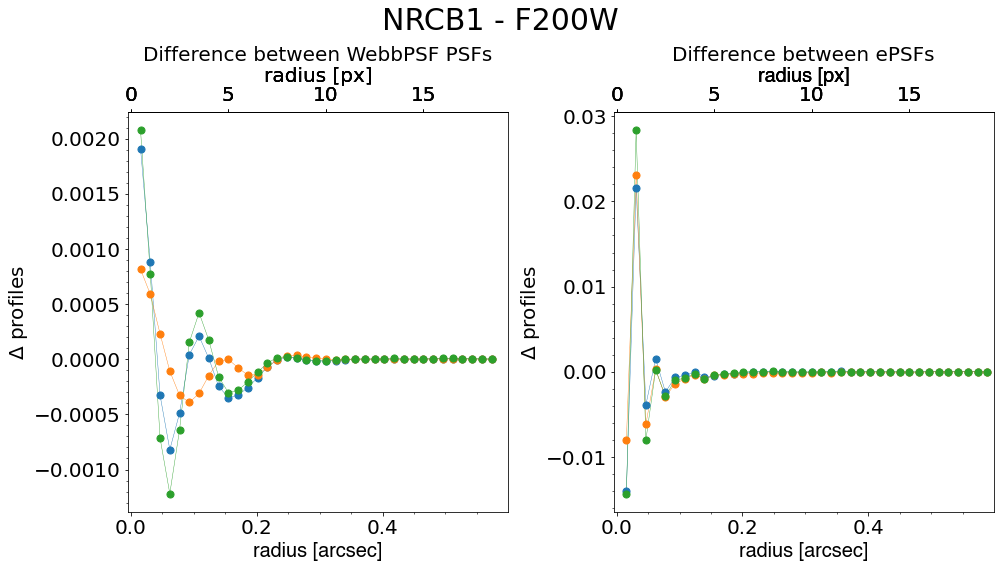

In [18]:
plt.figure(figsize=(14,8))
plt.suptitle(det+' - '+ filt, fontsize=30)

ax1 = plt.subplot(1, 2, 1)

xlim0 = rad_arcsec_epsf[0] - 0.02
xlim1 = np.max(rad_arcsec_epsf) + 0.01

ax1.set_xlim(xlim0, xlim1)
ax1.set_title('Difference between WebbPSF PSFs', fontsize=20)
ax1.set_xlabel('radius [arcsec]', fontdict=font2)
ax1.set_ylabel('$\Delta$ profiles', fontsize=20)
    
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

for i in range(num_psf_epsf-1):
    ax1.scatter(rad_arcsec_webbpsf, en_webbpsf_tot[0] - en_webbpsf_tot[i+1], s=50, zorder=1)
    ax1.plot(rad_arcsec_webbpsf, en_webbpsf_tot[0] -  en_webbpsf_tot[i+1], lw=0.4, zorder=0)
    ax1b = ax1.secondary_xaxis('top', functions=(arcsec2pix_sw, pix2arcsec_sw))
    ax1b.set_xlabel('radius [px]', fontsize=20)
    
ax2 = plt.subplot(1, 2, 2)

xlim0 = rad_arcsec_epsf[0] - 0.02
xlim1 = np.max(rad_arcsec_epsf) + 0.01

ax2.set_xlim(xlim0, xlim1)
ax2.set_title('Difference between ePSFs', fontsize=20)
ax2.set_xlabel('radius [arcsec]', fontdict=font2)
ax2.set_ylabel('$\Delta$ profiles', fontsize=20)
    
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

for i in range(num_psf_epsf-1):
    ax2.scatter(rad_arcsec_epsf, en_epsf_tot[0] - en_epsf_tot[i+1], s=50, zorder=1)
    ax2.plot(rad_arcsec_epsf, en_epsf_tot[0] -  en_epsf_tot[i+1], lw=0.4, zorder=0)
    ax2b = ax2.secondary_xaxis('top', functions=(arcsec2pix_sw, pix2arcsec_sw))
    ax2b.set_xlabel('radius [px]', fontdict=font2)

plt.tight_layout()

filename = 'difference_PSF_{}_{}_fov{}px_numPSF{}.png'.format(det, filt, fov_detsamp, num_psf_epsf)
    
#plt.savefig(os.path.join(figures_dir, filename))